In [1]:
import datetime 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import quandl

Gather data from Quandl

In [ ]:
while True:
    quandl.ApiConfig.api_key = input('Enter your Quandl API Key')
    name = input('Enter Quandl Ticker Symbol')
    buy_price = float(input("Entry Price"))
    
    ls = input("Are you long or short?")
    mul = float(input("ATR multiple"))
    n = int(input("ATR Period"))
    date_str = input("Entry Date")
    format_str = '%Y%m%d' # The format
    datetime_obj = datetime.datetime.strptime(date_str, format_str)
    a = datetime_obj
    
    print(a)
    end = datetime.datetime.now()
    data = quandl.get(name, start_date = a, end_date = end)
    data.rename(columns={'Settle': 'Close','Previous Day Open Interest':'OpenInterest'}, inplace=True)
    data
    data1 = data.empty  
#type(data1)
    if data1 == True:
        print("please enter a valid date")
        continue
    elif buy_price < data.loc[a]['Open'] or buy_price > data.loc[a]['High']:
        print("Please enter a valid buy price")
        continue
    elif data1 == False:
        print(data)
        break

In [3]:
#My inputs were as follows.
#API Key: My api Key
#Symbol: CHRIS/CME_ES1 (the Quandl symbol for the E-mini S&P 500 Futures contract)
#Entry Price: 3030
#Position: long
#Multiple: 7
#Period: 10
#Entry Date: 202061 (1st of June, 2020)

Calculate ATR using Wilder's EMA

In [4]:
def wwma(values, n):

    return values.ewm(alpha=1/n, min_periods=n, adjust=True).mean()

def atr(data, n):
    high = data['High']
    low = data['Low']
    close = data['Close']
    data['tr0'] = abs(high - low)
    data['tr1'] = abs(high - close.shift())
    data['tr2'] = abs(low - close.shift())
    tr = data[['tr0', 'tr1', 'tr2']].max(axis=1)
    data['atr'] = wwma(tr, n)
    data.drop(columns= ['tr0', 'tr1', 'tr2'], inplace=True)
    return data

Add respective trailing stop mechanisms with number two representing the trailing stop that will be plotted.

In [5]:
atr(data, n)
data['atr_ts1'] = ''
data['atr_ts2'] = ''
df = data
df['crossover'] = ''

Calculate for a long or short position.

In [6]:
if ls == 'long':
    df['atr_ts1'] = df['Close'] - (mul * df['atr'])
    df['atr_ts2'] = df['atr_ts1'].cummax()
    df['crossover'] = df['atr_ts2'] > df['Close']
elif ls == 'short':
    df['atr_ts1'] = df['Close'] + (mul * df['atr'])
    df['atr_ts2'] = df['atr_ts1'].cummin()
    df['crossover'] = df['atr_ts2'] < df['Close']
#df

Find the first date where crossover is true and therefore finding which date and close price the position is stopped out.

In [7]:
#the required date is the 1st result
df2 = df[df['crossover']==True]
df2.head(1)

,Open,High,Low,Last,Change,Close,Volume,OpenInterest,atr,atr_ts1,atr_ts2,crossover
Date,,,,,,,,,,,,
2020-09-21,3314.5,3326.25,3217.75,3273.75,-41.25,3275.0,2452727.0,2491348.0,72.438635,2767.929558,3297.460346,True


Slicing the dataframe in order to visualise the stop loss of the active position only. Enter the date found above.

In [9]:
#length of trade
lot = df.loc[:input('Date')]
lot.drop(['Open', 'High', 'Low', 'Last', 'Change', 'Volume', 'OpenInterest', 'atr', 'atr_ts1'], axis=1, inplace=True)
lot

Date 20200921


/Users/jaydenclark/Desktop/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Close,atr_ts2,crossover
Date,,,
2020-06-01,3054.00,NaN,False
2020-06-02,3077.00,NaN,False
2020-06-03,3117.75,NaN,False
2020-06-04,3110.50,NaN,False
2020-06-05,3186.75,NaN,False
...,...,...,...
2020-09-15,3405.25,3297.460346,False
2020-09-16,3389.50,3297.460346,False
2020-09-17,3361.50,3297.460346,False


Text(0, 0.5, 'CHRIS/CME_ES1')

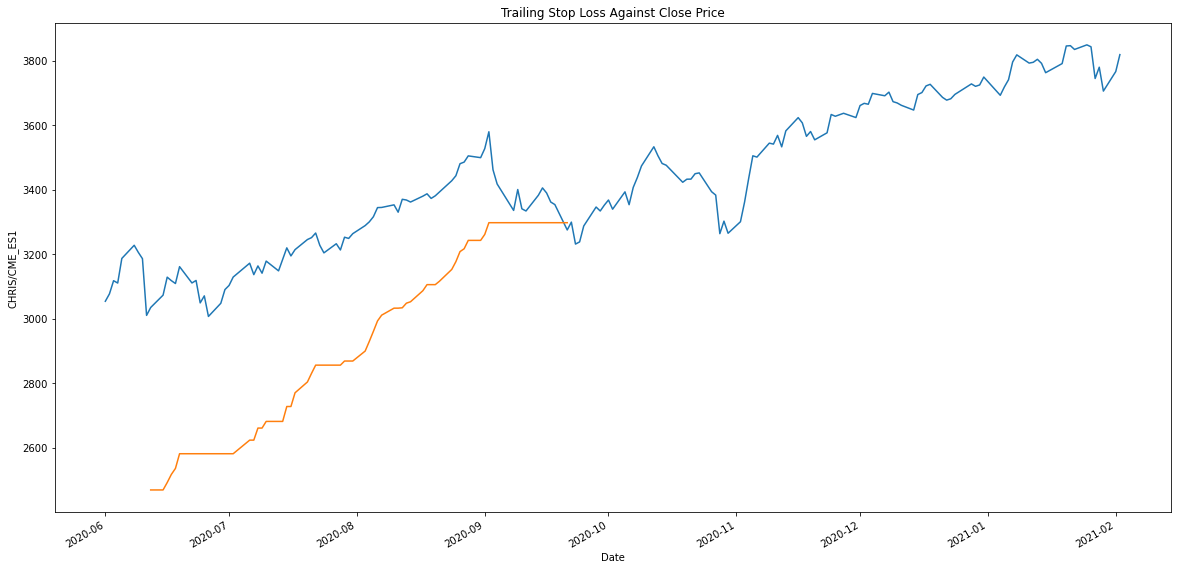

In [10]:
fig, ax = plt.subplots(figsize=(20,10), sharex = False, sharey = False)
data.loc[data.index, 'Close'].plot(ax=ax)
lot.loc[lot.index, 'atr_ts2'].plot(ax=ax)
ax.set_title('Trailing Stop Loss Against Close Price')
ax.set_ylabel(name)